# Extended Least Squares

Example created by Wilson Rocha Lacerda Junior

Here we import the NARMAX model, the metric for model evaluation and the methods to generate sample data for tests. Also, we import pandas for specific usage.

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results

## Generating 1 input 1 output sample data  

The data is generated by simulating the following model:
$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma$ is defined by the user.

In the next example we will generate a data with 3000 samples with white noise and selecting 90% of the data to train the model. 

In [2]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=1000, colored_noise=True, sigma=0.2, train_percentage=90
)

## Build the model

First we will train a model without the Extended Least Squares Algorithm for comparison purpose.

In [3]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares(unbiased=False)
model = FROLS(
    order_selection=False,
    n_terms=3,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator=estimator,
    basis_function=basis_function,
    err_tol=None,
)

In [4]:
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

0.5463756532162123


Clearly we have something wrong with the obtained model. See the *basic_steps* notebook to compare the results obtained using the same data but without colored noise. But let take a look in whats is wrong.

In [5]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

      Regressors  Parameters             ERR
0        x1(k-2)  9.0807E-01  7.42958856E-01
1         y(k-1)  2.8569E-01  8.25663362E-02
2  x1(k-1)y(k-1)  1.0677E-01  4.01292463E-03


## Biased parameter estimation

As we can observe above, the model structure is exact the same the one that generate the data. You can se that the ERR ordered the terms in the correct way. And this is an important note regarding the Error Reduction Ratio algorithm used here: __it is very robust to colored noise!!__ 

That is a great feature! However, although the structure is correct, the model *parameters* are not ok! Here we have a biased estimation! The real parameter for $y_{k-1}$ is $0.2$, not $0.3$.

In this case, we are actually modeling using a NARX model, not a NARMAX. The MA part exists to allow a unbiased estimation of the parameters. To achieve a unbiased estimation of the parameters we have the Extend Least Squares algorithm. Remember, if the data have only white noise, NARX is fine. 

Before applying the Extended Least Squares Algorithm we will run several NARX models to check how different the estimated parameters are from the real ones.

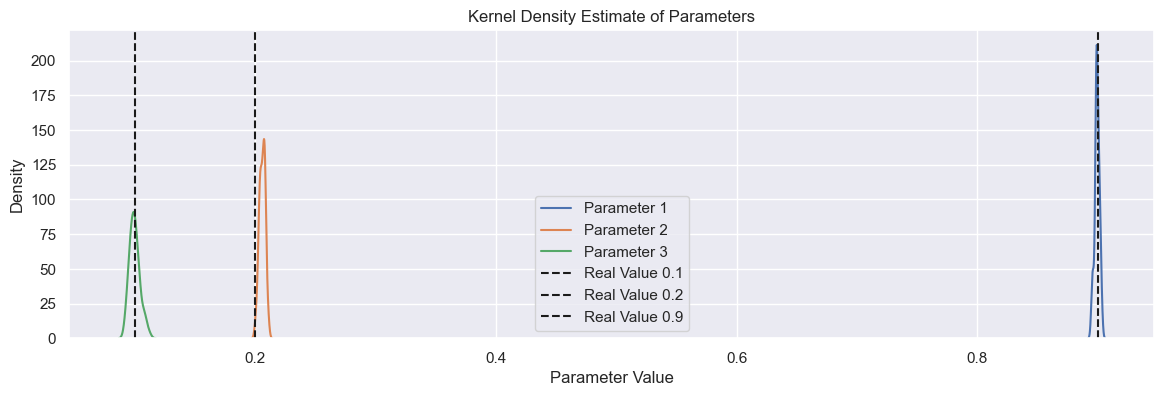

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

parameters = np.zeros([3, 50])

for i in range(50):
    x_train, x_valid, y_train, y_valid = get_siso_data(
        n=3000, colored_noise=True, train_percentage=90
    )

    model.fit(X=x_train, y=y_train)
    parameters[:, i] = model.theta.flatten()

# Set the theme for seaborn (optional)
sns.set_theme()

plt.figure(figsize=(14, 4))

# Plot KDE for each parameter
sns.kdeplot(parameters.T[:, 0], label="Parameter 1")
sns.kdeplot(parameters.T[:, 1], label="Parameter 2")
sns.kdeplot(parameters.T[:, 2], label="Parameter 3")

# Plot vertical lines where the real values must lie
plt.axvline(x=0.1, color="k", linestyle="--", label="Real Value 0.1")
plt.axvline(x=0.2, color="k", linestyle="--", label="Real Value 0.2")
plt.axvline(x=0.9, color="k", linestyle="--", label="Real Value 0.9")

plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Parameters")
plt.legend()
plt.show()

## Using the Extended Least Squares algorithm

As shown in figure above, we have a problem to estimate the parameter for $y_{k-1}$. Now we will use the Extended Least Squares Algorithm.

In SysIdentPy, just set *extended_least_squares* to *True* and the algorithm will be applied.

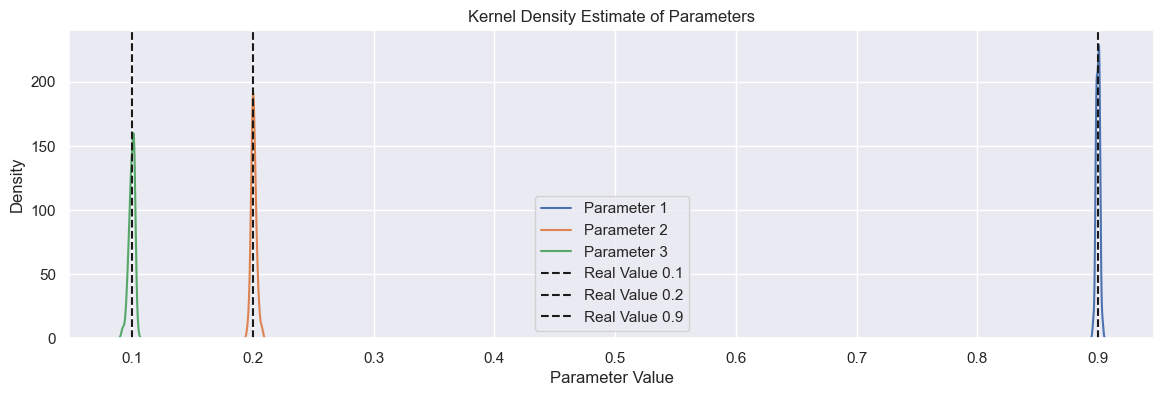

In [7]:
basis_function = Polynomial(degree=2)
estimator = LeastSquares(unbiased=True)
parameters = np.zeros([3, 50])

for i in range(50):
    x_train, x_valid, y_train, y_valid = get_siso_data(
        n=3000, colored_noise=True, train_percentage=90
    )

    model = FROLS(
        order_selection=False,
        n_terms=3,
        ylag=2,
        xlag=2,
        elag=2,
        info_criteria="aic",
        estimator=estimator,
        basis_function=basis_function,
    )

    model.fit(X=x_train, y=y_train)
    parameters[:, i] = model.theta.flatten()


plt.figure(figsize=(14, 4))

# Plot KDE for each parameter
sns.kdeplot(parameters.T[:, 0], label="Parameter 1")
sns.kdeplot(parameters.T[:, 1], label="Parameter 2")
sns.kdeplot(parameters.T[:, 2], label="Parameter 3")

# Plot vertical lines where the real values must lie
plt.axvline(x=0.1, color="k", linestyle="--", label="Real Value 0.1")
plt.axvline(x=0.2, color="k", linestyle="--", label="Real Value 0.2")
plt.axvline(x=0.9, color="k", linestyle="--", label="Real Value 0.9")

plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Parameters")
plt.legend()
plt.show()

Great! Now we have an unbiased estimation of the parameters!

## Note

Note: The Extended Least Squares is an iterative algorithm. In SysIdentpy the default is 30 iterations (`uiter=30`) because it is known from literature that the algorithm converges quickly (about 10 or 20 iterations).